<a href="https://www.kaggle.com/code/salahuddin1351/bitcoin-price-prediction-using-sarima?scriptVersionId=133640681" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Python Library

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import os
from scipy import stats
from itertools import product
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



# Exploratory Data Analysis (EDA)

In [2]:
def convert_bytes(size):
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0
    

In [3]:
for dirname, _, filenames in os.walk('input/'):
    for filename in filenames:
        featherFile = os.path.join(dirname,filename)
        featherFileSize = os.path.getsize(featherFile)
        filesize = convert_bytes(featherFileSize)
        print(f'{featherFile} size is', filesize, 'bytes')

In [4]:
# Read dataset
df = pd.read_csv('/kaggle/input/dataset/dataset.csv')





In [5]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [7]:
# We have to change format of Timestamp to dateTime
df['Timestamp'] = pd.to_datetime(df.Timestamp, unit = 's')
df.index = df['Timestamp']

# The resample() function is used to resample time-series data.
# 'D' indicates day
df = df.resample('D').mean()

# Resampling by month
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

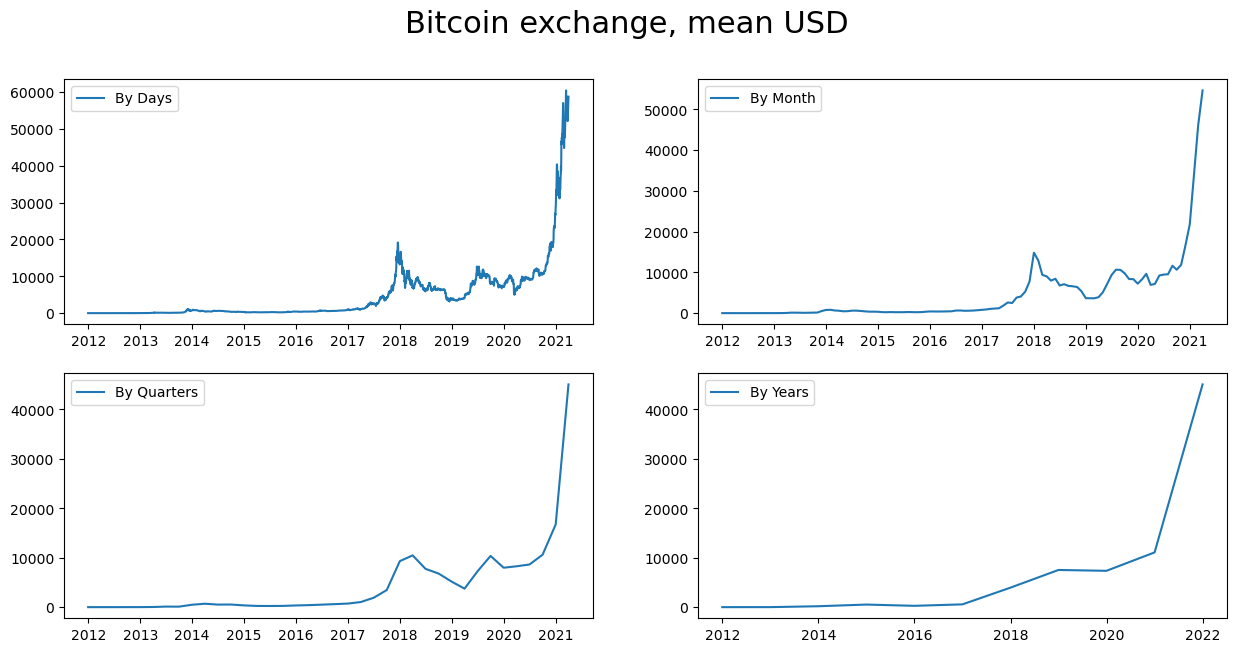

In [8]:
# Ploting data
fig = plt.figure(figsize = [15,7])
plt.suptitle('Bitcoin exchange, mean USD', fontsize = 22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label = 'By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label = 'By Month')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label = 'By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label = 'By Years')
plt.legend()
plt.show()

# Convert Time Series Data to stationary

Dickey-Fuller test: p = 0.998863


<Figure size 1500x700 with 0 Axes>

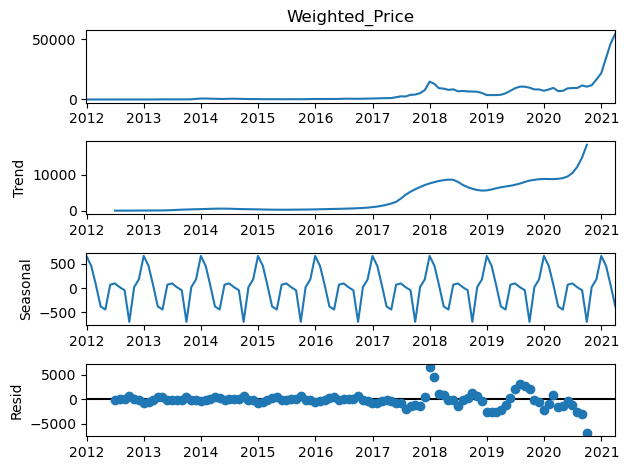

In [9]:
print("Dickey-Fuller test: p = %f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.figure(figsize = [15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
plt.show()


# Box-Cox Transformations

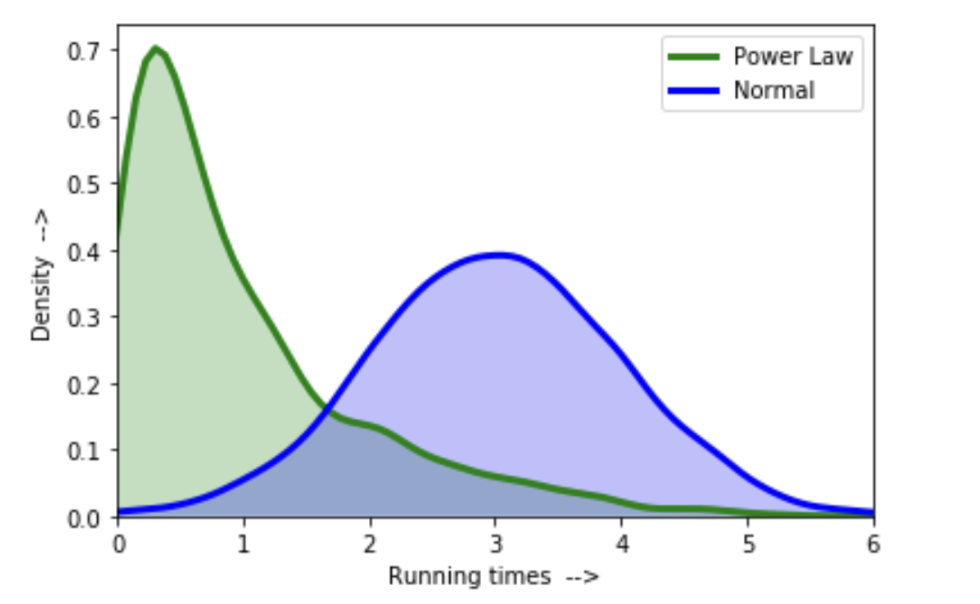
The transformation equation is as follows:
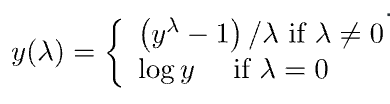

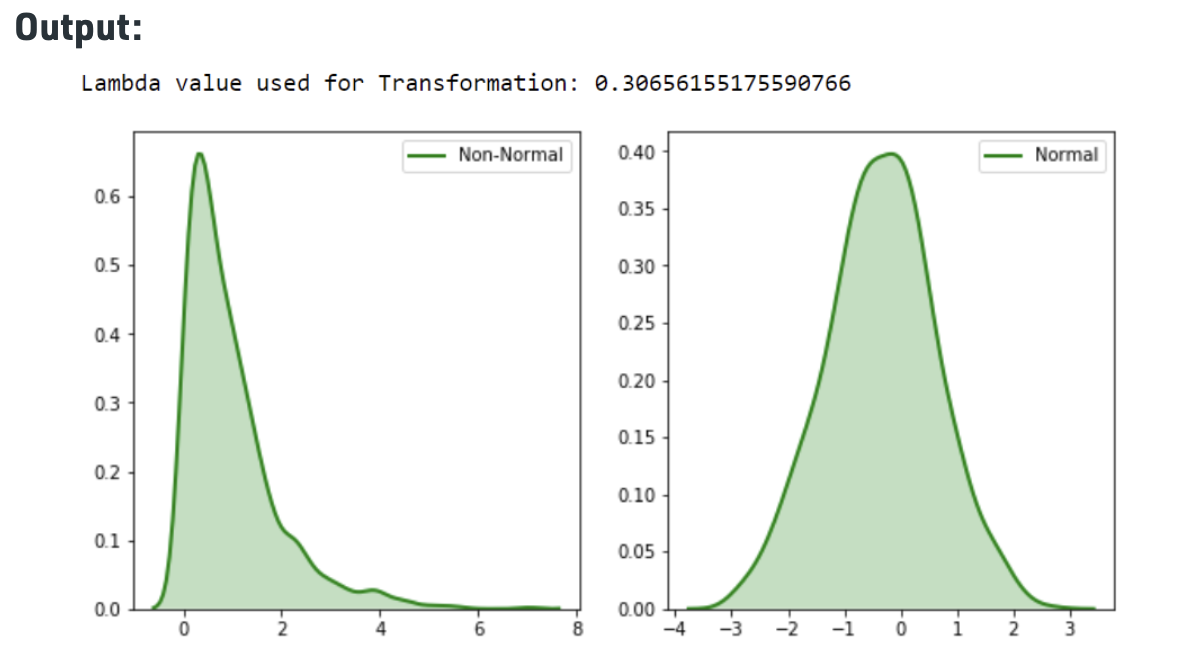





In [10]:
df_month['Weighted_Price_box'],lmbda = stats.boxcox(df_month.Weighted_Price)

print("Dickey-Fuller test: p = %f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])



Dickey-Fuller test: p = 0.998863


# Seasonal Differentiation


In [11]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)

print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])



Dickey-Fuller test: p=0.444282


# Regular Differentiation

Dickey-Fuller test: p=0.000024


<Figure size 1500x700 with 0 Axes>

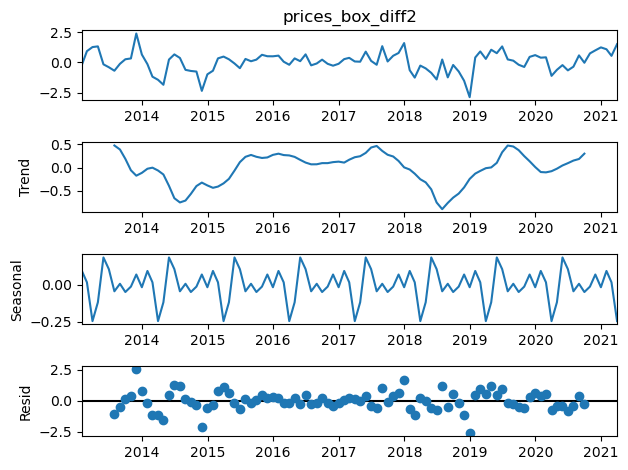

In [12]:
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL - decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()

print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()



# Autocorrelation and Partial Autocorrelation 

    
 * p,d,q
    * p AR model lags
    * d differencing
    * q MA lags






# Visualize the Correlarions

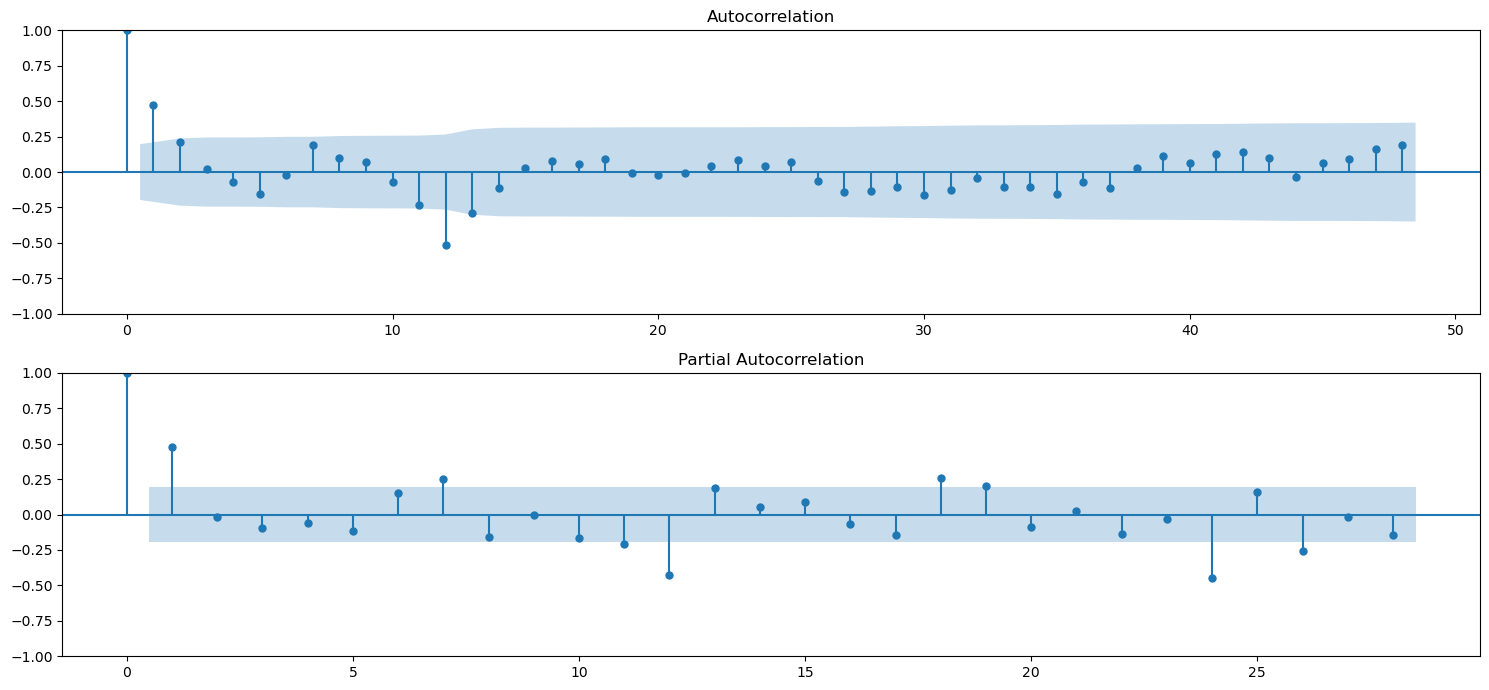

In [13]:
# Initial approcimation of parameters using Autocorrelation 
# and Partial Autocorrelation Plots

plt.figure(figsize = (15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(),
                        lags = 48, ax = ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(),
                         lags = 28, ax = ax)
plt.tight_layout()
plt.show()






In [14]:
#Initial approximation of parameters 
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D = 1
d = 1

In [15]:
parameters = product(ps, qs, Ps, Qs)

In [16]:
parameters_list = list(parameters)

In [17]:
# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box,
                                         order = (param[0], d, param[1]),
                                         seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
    
        
        
        
        
        
        
        
        

In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters','aic']
print(result_table.sort_values(by='aic', ascending = True).head())


      parameters         aic
19  (1, 0, 0, 1)  173.616296
21  (1, 0, 1, 1)  174.766384
25  (1, 1, 0, 1)  175.547021
37  (2, 0, 0, 1)  175.554321
7   (0, 1, 0, 1)  175.589433


In [19]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Thu, 15 Jun 2023   AIC                            173.616
Time:                                      05:59:04   BIC                            181.402
Sample:                                  12-31-2011   HQIC                           176.766
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4253      0.085      5.029      0.000       0.260       0.591
ma.S.L12      -0.99

# Analysis of residues






Dickey-Fuller test:: p=0.000000


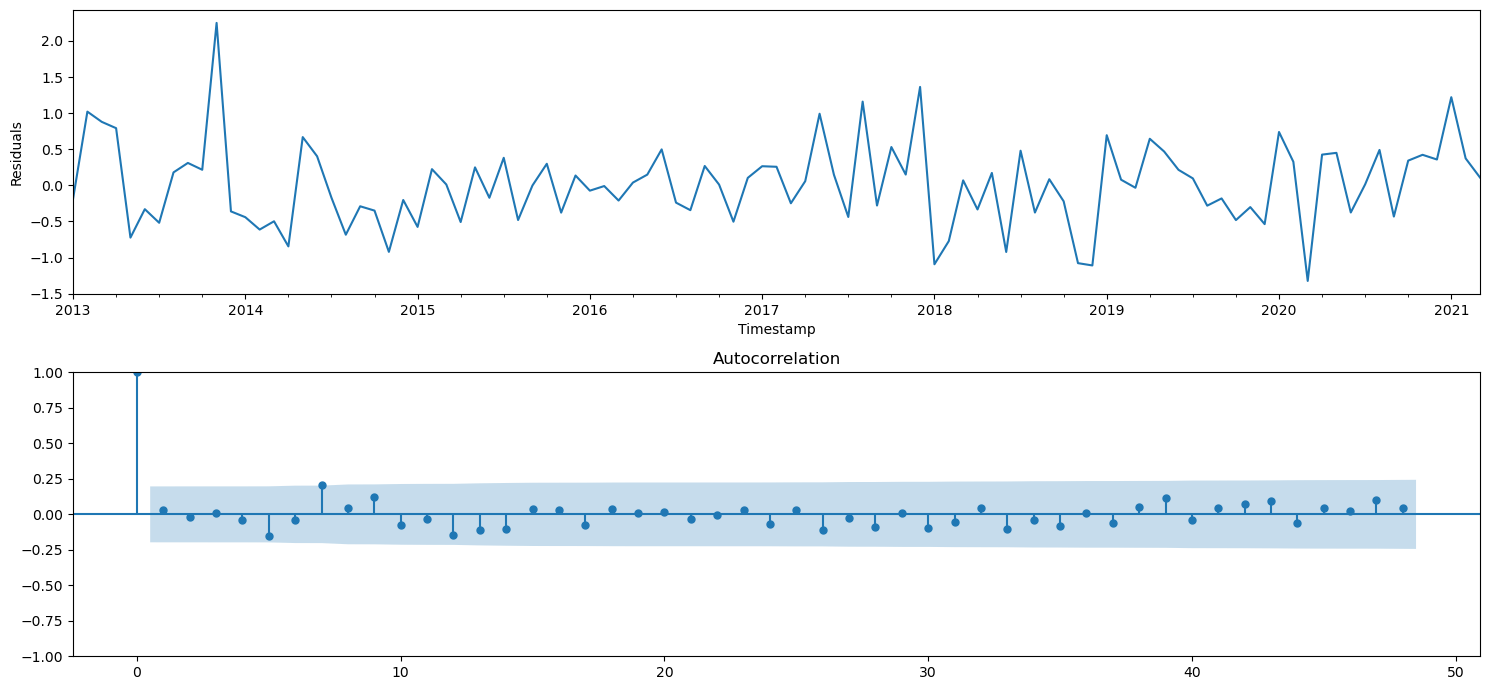

In [20]:
plt.figure(figsize = (15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(),lags = 48, ax = ax)

print("Dickey-Fuller test:: p=%f"% sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()






# Prediction

In [21]:
#inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return (np.exp(y))
    else:
        return (np.exp(np.log(lmbda * y + 1)/lmbda))

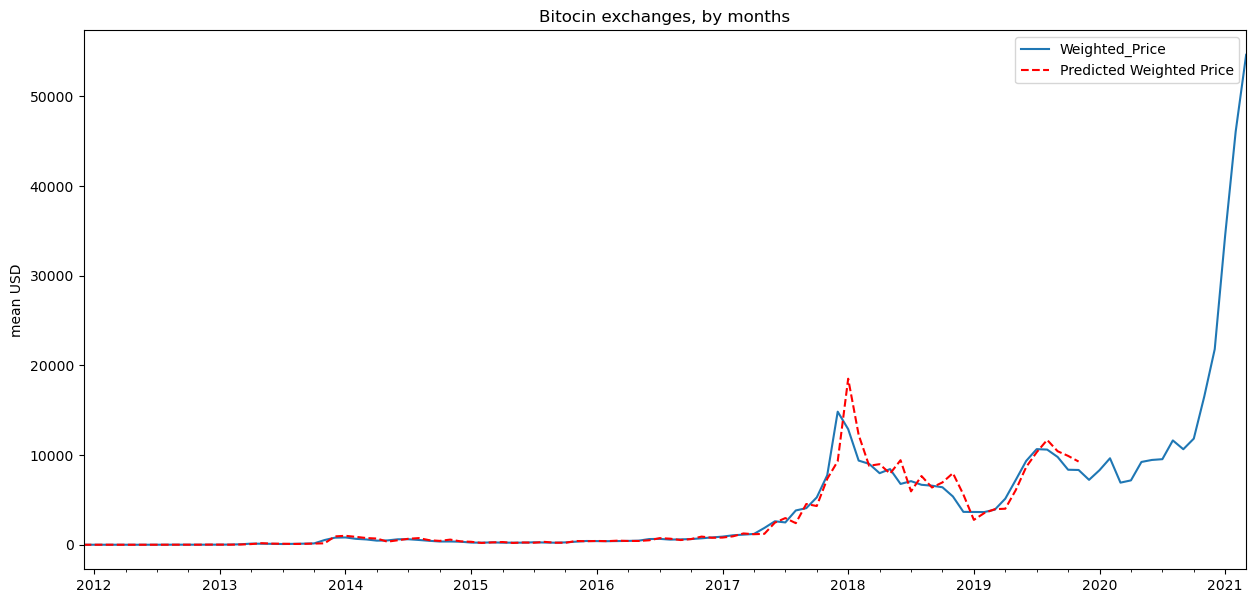

In [22]:
#Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = []

future = pd.DataFrame(index=date_list, columns=df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0,end=95),lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls = '--',label = 'Predicted Weighted Price')
plt.legend()
plt.title('Bitocin exchanges, by months')
plt.ylabel('mean USD')
plt.show()




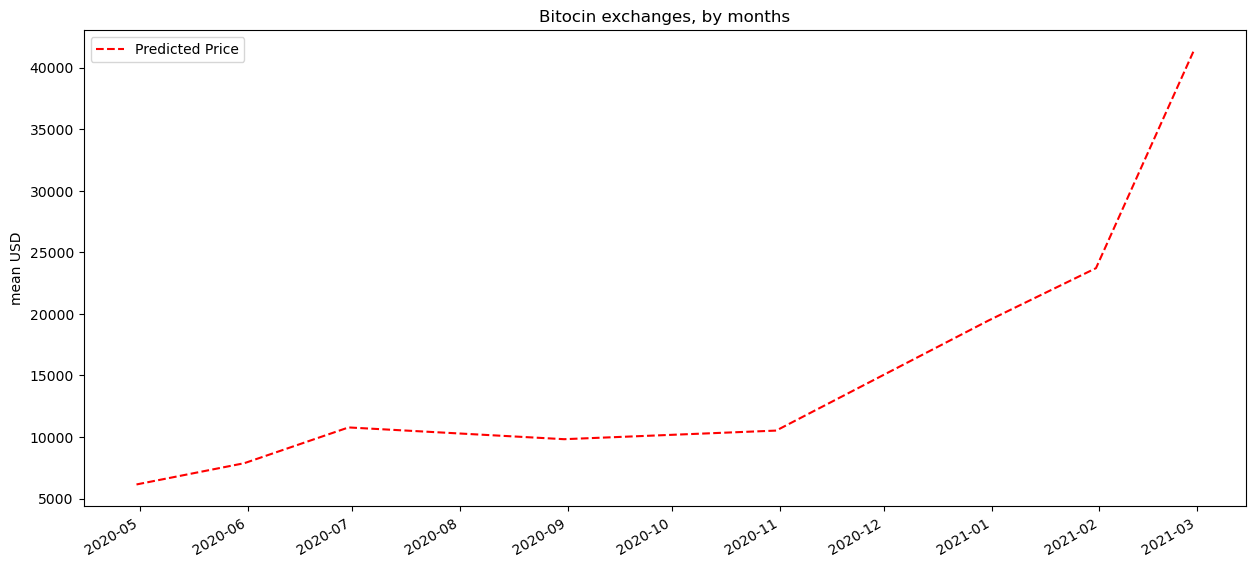

In [23]:
#Predicted Price
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2020, 3, 30),datetime(2020, 4, 30),datetime(2020, 5, 31),datetime(2020, 6, 30), datetime(2020, 8, 31),
             datetime(2020, 10, 31), datetime(2020, 12, 31), datetime(2021, 1, 31),
             datetime(2021, 1, 31),datetime(2021, 2,28),datetime(2021, 3,20)]

future = pd.DataFrame(index=date_list, columns=df_month.columns)
df_month2 = future
df_month2['forecast'] = invboxcox(best_model.predict(start=0,end=1000),lmbda)
plt.figure(figsize=(15,7))

df_month2.forecast.plot(color='r', ls = '--',label = 'Predicted Price')
plt.legend()
plt.title('Bitocin exchanges, by months')
plt.ylabel('mean USD')
plt.show()



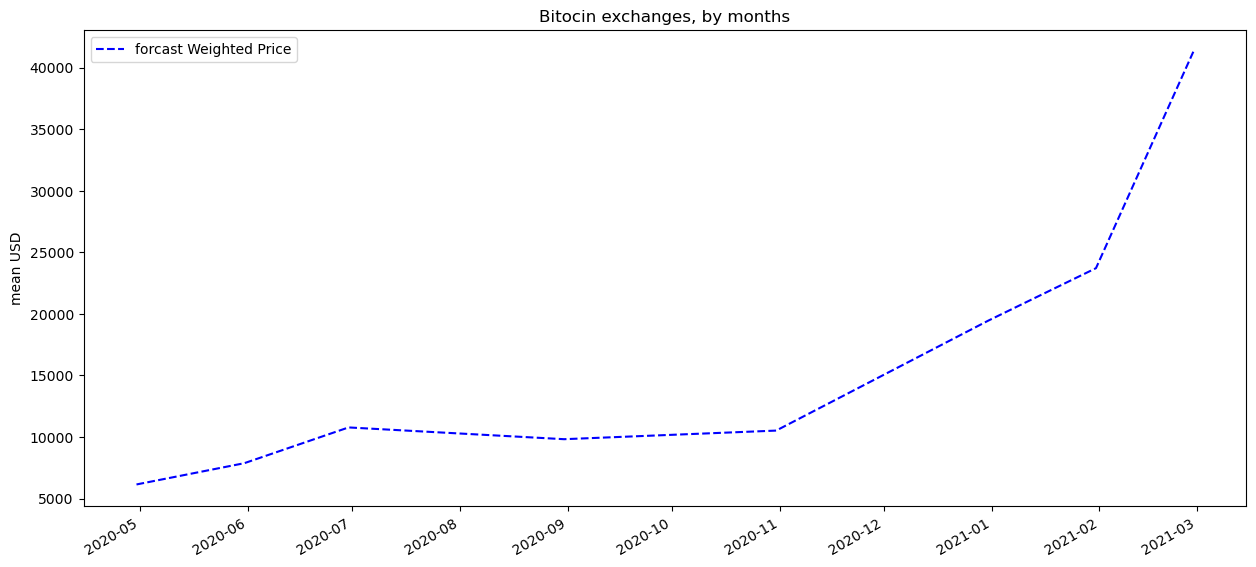

In [24]:
#forcast Weighted Price
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2020, 3, 30),datetime(2020, 4, 30),datetime(2020, 5, 31),datetime(2020, 6, 30), datetime(2020, 8, 31),
             datetime(2020, 10, 31), datetime(2020, 12, 31), datetime(2021, 1, 31),
             datetime(2021, 1, 31),datetime(2021, 2,28),datetime(2021, 3,20)]

future = pd.DataFrame(index=date_list, columns=df_month.columns)
df_month2 = future
df_month2['forecast'] = invboxcox(best_model.predict(start=0,end=1000),lmbda)
plt.figure(figsize=(15,7))

df_month2.forecast.plot(color='b', ls = '--',label = 'forcast Weighted Price')
plt.legend()
plt.title('Bitocin exchanges, by months')
plt.ylabel('mean USD')
plt.show()


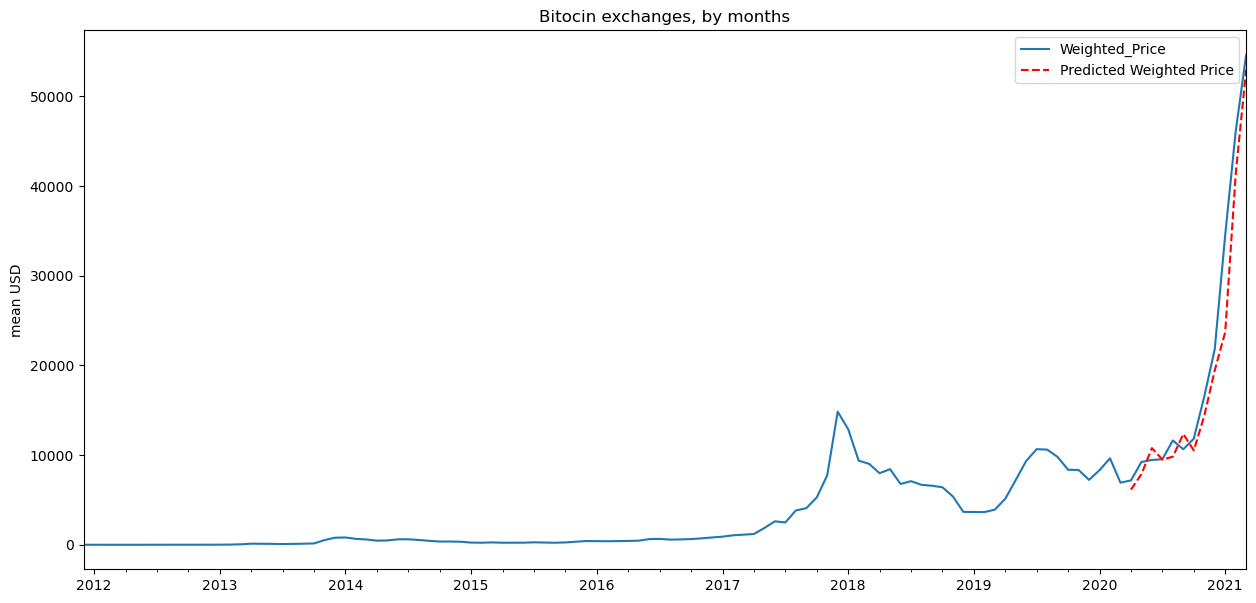

In [25]:
#Predion
df_month2 = df_month[['Weighted_Price']]
date_list = []

future = pd.DataFrame(index=date_list, columns=df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=100,end=120),lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls = '--',label = 'Predicted Weighted Price')
plt.legend()
plt.title('Bitocin exchanges, by months')
plt.ylabel('mean USD')
plt.show()